  # GLOBAL SETTINGS

In [1]:
# python peripherals
import random
import os
import sys
import math
sys.path.insert(1, os.path.join(sys.path[0], '../..'))

# numpy
import numpy

# pandas
import pandas

# ipython
from IPython.display import display, HTML

# matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines

# pytorch
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data import DataLoader

# deep signature
from deep_signature.utils import utils
from deep_signature.data_generation.curve_generation import LevelCurvesGenerator
from deep_signature.data_manipulation import curve_processing
from deep_signature.nn.datasets import DeepSignatureTupletsDataset
from deep_signature.nn.networks import DeepSignatureArcLengthNet
from deep_signature.nn.networks import DeepSignatureCurvatureNet
from deep_signature.nn.losses import ContrastiveLoss
from deep_signature.nn.trainers import ModelTrainer
from deep_signature.data_manipulation import curve_sampling
from deep_signature.data_manipulation import curve_processing
from deep_signature.linalg import euclidean_transform
from deep_signature.linalg import affine_transform

# common
from common import settings
from common import utils as common_utils

# notebooks
from notebooks.utils import utils as notebook_utils


  # IMPORT PACKAGES

In [2]:
# plt.style.use("dark_background")

transform_type = 'affine'

if transform_type == 'euclidean':
    level_curves_arclength_tuplets_dir_path = settings.level_curves_euclidean_arclength_tuplets_dir_path
    level_curves_arclength_tuplets_results_dir_path = settings.level_curves_euclidean_arclength_tuplets_results_dir_path
elif transform_type == 'equiaffine':
    level_curves_arclength_tuplets_dir_path = settings.level_curves_equiaffine_arclength_tuplets_dir_path
    level_curves_arclength_tuplets_results_dir_path = settings.level_curves_equiaffine_arclength_tuplets_results_dir_path
elif transform_type == 'affine':
    level_curves_arclength_tuplets_dir_path = settings.level_curves_affine_arclength_tuplets_dir_path
    level_curves_arclength_tuplets_results_dir_path = settings.level_curves_affine_arclength_tuplets_results_dir_path

if transform_type == 'euclidean':
    level_curves_curvature_tuplets_dir_path = settings.level_curves_euclidean_curvature_tuplets_dir_path
    level_curves_curvature_tuplets_results_dir_path = settings.level_curves_euclidean_curvature_tuplets_results_dir_path
elif transform_type == 'equiaffine':
    level_curves_curvature_tuplets_dir_path = settings.level_curves_equiaffine_curvature_tuplets_dir_path
    level_curves_curvature_tuplets_results_dir_path = settings.level_curves_equiaffine_curvature_tuplets_results_dir_path
elif transform_type == 'affine':
    level_curves_curvature_tuplets_dir_path = settings.level_curves_affine_curvature_tuplets_dir_path
    level_curves_curvature_tuplets_results_dir_path = settings.level_curves_affine_curvature_tuplets_results_dir_path

  # CURVES

In [3]:
# curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
# limit = 10
# color_map = plt.get_cmap('rainbow', limit)
# for i, curve in enumerate(curves[:limit]): 
#     fig, ax = plt.subplots(1, 1, figsize=(80,40))
#     for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#         label.set_fontsize(30)
#     ax.axis('equal')
#     notebook_utils.plot_curve(ax=ax, curve=curve, linewidth=5)
#     plt.show()


  # LEARNING CURVE

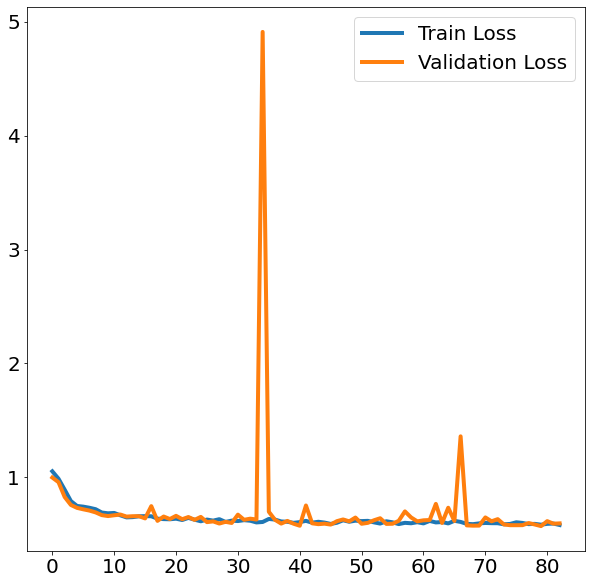

In [4]:
latest_subdir = common_utils.get_latest_subdirectory(level_curves_arclength_tuplets_results_dir_path)
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()

# results2 = numpy.load(f"C:/deep-signature-data/level-curves/results/tuplets/arclength/2021-01-14-02-42-52/results.npy", allow_pickle=True).item()

epochs = results['epochs']
batch_size = results['batch_size']
start_index = 0
train_loss_array = results['train_loss_array'][start_index:]
validation_loss_array = results['validation_loss_array'][start_index:]

# train_loss_array2 = results2['train_loss_array']
# validation_loss_array2 = results2['validation_loss_array']

epochs_list = numpy.array(range(len(train_loss_array)))
# epochs_list2 = numpy.array(range(len(train_loss_array2)))

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)

ax.plot(epochs_list, train_loss_array, label='Train Loss', linewidth=4.0)
ax.plot(epochs_list, validation_loss_array, label='Validation Loss', linewidth=4.0)

# ax.plot(epochs_list2, train_loss_array2, label='Train Loss2', linewidth=4.0)
# ax.plot(epochs_list2, validation_loss_array2, label='Validation Loss2', linewidth=4.0)

plt.legend(fontsize=20, title_fontsize=20)

# print(train_loss_array)
# print(validation_loss_array)
plt.show()

  # ARC-LENGTH

## INITIALIZATION ##

In [5]:
# constants
limit = 10
arclength_sample_points = 40
curvature_supporting_points_count = 3
curvature_max_offset = 6
curvature_sample_points = 2 * curvature_supporting_points_count + 1
arclength_section_length = 70
curvature_step = 1
comparison_curves_count = 1
device = torch.device('cuda')

# if we're in the equiaffine case, snap 'step' to the closest mutiple of 3 (from above)
# if transform_type == "equiaffine":
#     step = int(3 * numpy.ceil(step / 3))

# package settings
torch.set_default_dtype(torch.float64)
numpy.random.seed(60)

# create models
arclength_model = DeepSignatureArcLengthNet(sample_points=arclength_sample_points).cuda()
curvature_model = DeepSignatureCurvatureNet(sample_points=curvature_sample_points).cuda()

# load arclength model state
latest_subdir = common_utils.get_latest_subdirectory(level_curves_arclength_tuplets_results_dir_path)
# latest_subdir = common_utils.get_latest_subdirectory(settings.level_curves_equiaffine_arclength_tuplets_results_dir_path)
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()
arclength_model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
arclength_model.eval()

# load curvature model state
latest_subdir = common_utils.get_latest_subdirectory(level_curves_curvature_tuplets_results_dir_path)
results = numpy.load(f"{latest_subdir}/results.npy", allow_pickle=True).item()
curvature_model.load_state_dict(torch.load(results['model_file_path'], map_location=device))
curvature_model.eval()

# load curves (+ shuffle)
curves = LevelCurvesGenerator.load_curves(dir_path=settings.level_curves_dir_path_train)
numpy.random.shuffle(curves)
curves = curves[:limit]

# create color map
color_map = plt.get_cmap('rainbow', limit)


  ## EVALUATE ARC-LENGTH

In [6]:
import warnings
warnings.filterwarnings("ignore")

true_arclength_colors = ['#FF8C00', '#444444']
predicted_arclength_colors = ['#AA0000', '#00AA00']
sample_colors = ['#AA0000', '#00AA00']
curve_colors = ['#AA0000', '#00AA00']

curve_records = notebook_utils.generate_curve_records(
    arclength_model=arclength_model,
    curvature_model=curvature_model,
    curves=curves,
    transform_type=transform_type,
    comparison_curves_count=comparison_curves_count,
    section_points_count=arclength_sample_points,
    neighborhood_supporting_points_count=curvature_supporting_points_count)

# notebook_utils.plot_curve_arclength_comparisions(
#     curve_records=curve_records, 
#     true_arclength_colors=true_arclength_colors, 
#     predicted_arclength_colors=predicted_arclength_colors, 
#     sample_colors=sample_colors, 
#     curve_color='#FF8C00', 
#     anchor_color='#3333FF', 
#     first_anchor_color='#FF0FF0')

notebook_utils.plot_curve_arclength_comparisons(
    curve_records=curve_records, 
    curve_colors=curve_colors)

# notebook_utils.plot_curve_curvature_comparisons(
#     curve_records=curve_records, 
#     curve_colors=curve_colors)

# notebook_utils.plot_curve_signature_comparisions(
#     curve_records=curve_records, 
#     curve_colors=curve_colors)